# Deep Learning Final Project 2019/2020 - Group 13

## Use of GAN’s to Generate Synthetic Data:  Medical Data Case Study 

## Authors: 
- Inês Diogo (m20190301)
- Lara Neves (m20190867) 
- Susana Paço (m20190821)

## Index:

* [1. Brief Data Analysis](#bda)
* [2. Data Preprocessing](#dpp)
* [3. Feature Selection and Feature Engineering](#fe)
* [4. Outliers, Normalization and Oversampling](#ono)
* [5. Dataset Imbalance](#di)
* [6. Naive Bayes Classifier](#m)
* [7. Generative Adversarial Networks](#gan)



First, import the necessary packages:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,f1_score
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
from sklearn.model_selection import train_test_split,KFold
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

<hr>
<a class="anchor" id="bda">
    
## 1. Brief Data Analysis
    
</a>

#### Data Input

In [2]:
train = pd.read_csv(r'./Data/train.csv')

#### Number of variables and observations

In [3]:
train.shape

(900, 11)

The features and their data type:

In [4]:
train.dtypes

Patient_ID                             int64
Family_Case_ID                         int64
Severity                               int64
Name                                  object
Birthday_year                        float64
Parents or siblings infected           int64
Wife/Husband or children infected      int64
Medical_Expenses_Family                int64
Medical_Tent                          object
City                                  object
Deceased                               int64
dtype: object

In [5]:
train.describe()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Deceased
count,900.000000,900.000000,900.000000,723.000000,900.000000,900.000000,900.000000,900.000000
mean,450.500000,14305.827778,2.313333,1990.266943,0.380000,0.521111,895.743333,0.614444
std,259.951919,25418.153900,0.834223,14.523335,0.803247,1.098385,1385.829926,0.486997
min,1.000000,345.000000,1.000000,1940.000000,0.000000,0.000000,0.000000,0.000000
25%,225.750000,8203.000000,2.000000,1982.000000,0.000000,0.000000,221.000000,0.000000
50%,450.500000,13593.500000,3.000000,1992.000000,0.000000,0.000000,405.000000,1.000000
75%,675.250000,18906.500000,3.000000,1999.500000,0.000000,1.000000,861.250000,1.000000
max,900.000000,742836.000000,3.000000,2019.000000,6.000000,8.000000,14345.000000,1.000000


(8.5, -0.5)

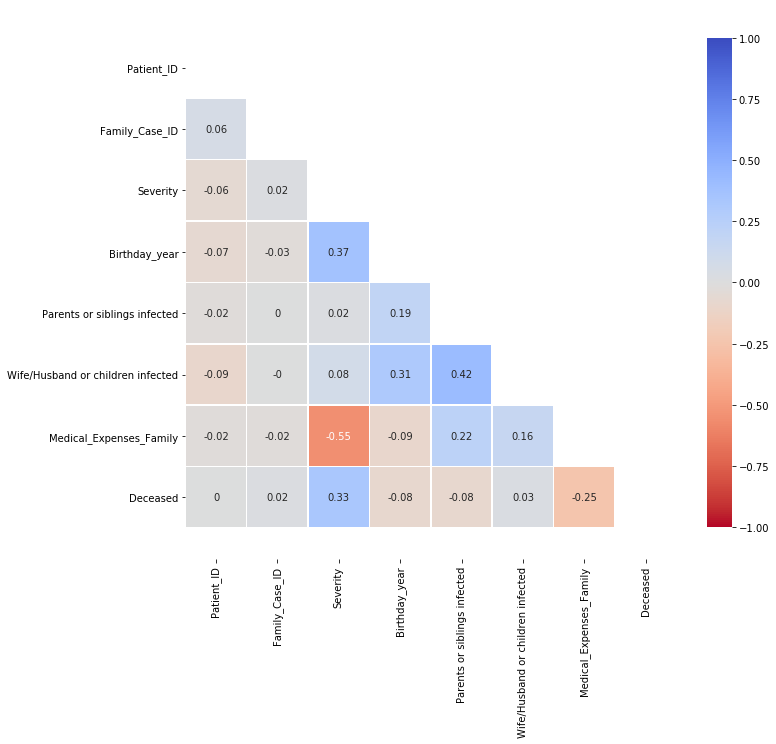

In [6]:
corr_matrix = train.corr().round(2)

%matplotlib inline

# Note that the upper triangle of the correlation matrix is symmetrical to the lower triangle half. Thus, it's
#best to hide it by defining a mask:
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True


fig, ax = plt.subplots(figsize=(11, 15))                                         #creates a figure with just one subplot, but increases figure size 

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,                                                #only the upper triangle will be shown
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm_r',                                        #reverse cool-warm colour gradient 
                      cbar_kws = {'shrink': .6,
                               "ticks":[-1,-0.75,-0.5,-0.25,0,0.25,0.50,0.75,1]}, #spacing between bins in the colour bar 
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                     )

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

#If the bottom half gets cropped use:
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<hr>
<a class="anchor" id="dpp">
    
## 2. Data Preprocessing

</a>

#### Categorical Variables


In [7]:
cat_train = train.select_dtypes(include=[object])
cat_train

,Name,Medical_Tent,City
0,Miss Linda Betty,NaN,Santa Fe
1,Ms. Ramona Elvira,NaN,Albuquerque
2,Mr. Mario Vernon,NaN,Santa Fe
3,Mr. Hector Joe,NaN,Santa Fe
4,Ms. Jennie Debra,NaN,Santa Fe
...,...,...,...
895,Ms. Linda Wilcox,NaN,Santa Fe
896,Mr. Haiden Vance,NaN,Santa Fe
897,Miss Anaiya Love,NaN,Taos
898,Mr. Robert Williams,NaN,Santa Fe


#### City variable
Initially we started by doing a simple encoding of the __City__ variable. The goal was to eventually test the possibility of enconding the cities proportionally to the distance between them however this was ultimately proven to be unnecessary.

In [8]:
train.City.unique()

array(['Santa Fe', 'Albuquerque', 'Taos', nan], dtype=object)

In [9]:
encoder_city = {"City": {'Santa Fe': 0, 'Albuquerque': 1, 'Taos': 2}}
train.replace(encoder_city, inplace=True)
train.City.unique()

array([ 0.,  1.,  2., nan])

#### Medical_Tent variable 


In [10]:
train.Medical_Tent.unique()

array([nan, 'F', 'B', 'A', 'E', 'C', 'D', 'G', 'T'], dtype=object)

Due to there being 8 different strings for the different medical tents, using OneHotEncoder would imply the creation of 8 column features which would, most likely, overcomplicate the model and was ultimately proven to be unnecessary. As such we will only replace the strings like we did with the __City__ variable.

In [11]:
encoder_Medical_Tent = {"Medical_Tent": {'A': 0,'B': 1,'C': 2,'D': 3,'E': 4,'F': 5,'G': 6,'T': 7,}}
train.replace(encoder_Medical_Tent, inplace=True)

train.Medical_Tent.unique()

array([nan,  5.,  1.,  0.,  4.,  2.,  3.,  6.,  7.])

<hr>
<a class="anchor" id="fe">
    
## 3. Feature Selection and Feature Engineering
    
</a>

#### Identifying variables and Feature Engineering
In order to anonymize the data it's necessary to remove the information about the name or family of the patient. However these names hold valuable information which should be used to improve our model.

Each name has the information of whether or not the person is married as well as their gender: Mr.,Mrs., Master and Miss. So we created 4 Title columns that are 1 if the person is female and married __Title_Ms__ while 0 otherwise. And so on for __Title_Master__, __Title_Mr__ and __Title_Miss__.

In [12]:
#create column title
new = train["Name"].str.split(" ", n = 1, expand = True) 
train["Title"]= new[0] 
train["Name"]= new[1] 

In [13]:
#separate first from family name
new = train["Name"].str.split(" ", n = 1, expand = True) 
train["First_Name"]= new[0] 
train["Family_Name"]= new[1] 

In [14]:
train.drop(columns = ['Name','Patient_ID','Family_Case_ID'], inplace = True)

In [15]:
from sklearn.preprocessing import LabelEncoder

#family name to label encoder
lb_make = LabelEncoder()
train["Family_Name"] = lb_make.fit_transform(train["Family_Name"])

train.drop(columns = ['First_Name','Family_Name'], inplace = True)

##### Variable Gender
Using the initials from the variable name it was possible to create a variable gender.

We created the encoded variable Gender, based in Title variable. Miss, Ms. and Mrs. are female. Mr. and Master are male.

In [16]:
train.Title.unique()

array(['Miss', 'Ms.', 'Mr.', 'Master'], dtype=object)

In [17]:
train['Gender']=train['Title']
train.Gender.replace(['Miss','Ms.','Mr.','Master'],[0,0,1,1], inplace=True)

train.drop(columns = ['Title'], inplace = True)

#### Missing Values

In [18]:
train.isnull().sum()

Severity                               0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
Gender                                 0
dtype: int64

Imputing the missing values with K-Nearest Neighbor Imputer

In [19]:
KNNimputer = KNNImputer(n_neighbors=3, weights="uniform")
#Fitting the imputer to the data and transforming it back into the original traindf 
train[:]= KNNimputer.transform(KNNimputer.fit_transform(train))

In [20]:
train.isnull().sum()

Severity                             0
Birthday_year                        0
Parents or siblings infected         0
Wife/Husband or children infected    0
Medical_Expenses_Family              0
Medical_Tent                         0
City                                 0
Deceased                             0
Gender                               0
dtype: int64

In [21]:
train_data = train.drop(columns = ['Deceased'])
train_target = train.Deceased


#### Creating new features
The number of 'Wife/Husband or children infected' and number of 'Parents or siblings infected' variables can be added together to simply represent the number of family members infected. It simplifies the model without any loss of information.

In [22]:
train_data['family_infected'] = train_data['Wife/Husband or children infected'] + train_data['Parents or siblings infected']

It's reasonable to assume that the vast majority of people that have family_infected equal to 0 are likely to not have any family. Based on this assumption, not having family can be a determining factor in the likelihood of catching the virus infection or even the outcome of illness, as people who live alone are less likely to catch the virus while at the same time if they do catch the virus, they are more likely to get serious complications from the disease as they won't have the tipical support system a family provides. 

As such we created a new feature __is_alone__ that represents whether a parson has zero family members infected or 1 otherwise.

In [23]:
train_data['is_alone'] = np.where(train_data.family_infected == 0.0, 1, 0)

In [24]:
train_data

,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Gender,family_infected,is_alone
0,3.0,1985.333333,0.0,0.0,225.0,4.666667,0.0,0.0,0.0,1
1,1.0,1966.000000,0.0,1.0,1663.0,2.000000,1.0,0.0,1.0,0
2,3.0,1982.000000,0.0,0.0,221.0,4.666667,0.0,1.0,0.0,1
3,3.0,1997.000000,0.0,0.0,220.0,5.000000,0.0,1.0,0.0,1
4,3.0,1994.000000,0.0,0.0,222.0,4.666667,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
895,3.0,1998.000000,1.0,1.0,344.0,4.000000,0.0,0.0,2.0,0
896,3.0,2006.000000,0.0,0.0,258.0,5.333333,0.0,1.0,0.0,1
897,3.0,1990.000000,0.0,0.0,214.0,5.000000,2.0,0.0,0.0,1
898,2.0,1994.000000,1.0,1.0,812.0,2.000000,0.0,1.0,2.0,0



#### Relevancy and Redundancy
Starting by using __SelectKBest__ to show the top most relevant features.

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = train.drop(columns = 'Deceased')
y = train.Deceased

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                               Specs          Score
4            Medical_Expenses_Family  124855.059626
7                             Gender      93.257222
0                           Severity      30.041468
5                       Medical_Tent      11.727505
2       Parents or siblings infected      10.480534
6                               City       9.592523
3  Wife/Husband or children infected       2.254112
1                      Birthday_year       1.303240


In [26]:
#order features by correlation index 
corr_matrix = train.corr()
corr_matrix["Deceased"].sort_values(ascending=False)

Deceased                             1.000000
Gender                               0.541536
Severity                             0.333286
Medical_Tent                         0.144328
Wife/Husband or children infected    0.032909
Parents or siblings infected        -0.082862
City                                -0.097586
Birthday_year                       -0.121809
Medical_Expenses_Family             -0.254510
Name: Deceased, dtype: float64

In [27]:
train_columns = train_data.columns
train_columns

Index(['Severity', 'Birthday_year', 'Parents or siblings infected',
       'Wife/Husband or children infected', 'Medical_Expenses_Family',
       'Medical_Tent', 'City', 'Gender', 'family_infected', 'is_alone'],
      dtype='object')

<hr>
<a class="anchor" id="ono">
    
## 4. Outliers, Normalization and Oversampling

</a>

In [28]:
from scipy import stats

Q1 = train_data.quantile(0.25)
Q3 = train_data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Severity                               1.000000
Birthday_year                         17.000000
Parents or siblings infected           0.000000
Wife/Husband or children infected      1.000000
Medical_Expenses_Family              640.250000
Medical_Tent                           2.666667
City                                   1.000000
Gender                                 1.000000
family_infected                        1.000000
is_alone                               1.000000
dtype: float64


### Normalizing Data 

After extensive testing, it was clear that the RobustScaler as a method of normalization is the one that gives the best results. This is to be expected as it's the most robust to outliers, which are present in the dataset as seen from the IQR computation above.

Additionally, removing the standardization severely impacted the creation of the synthectic data with GAN.

In [29]:
from sklearn.preprocessing import RobustScaler

rb_scaler = RobustScaler()

rb_scaler.fit(train_data)
#Now apply the transformations to the data:
train_data = rb_scaler.transform(train_data)

---
<hr>
<a class="anchor" id="di">
    
## 5. Dataset Imbalance 

</a>

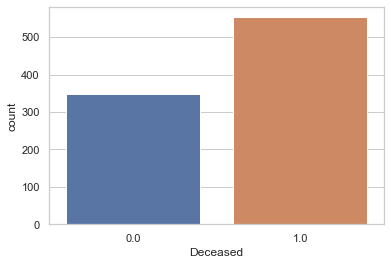

In [30]:
%matplotlib inline
sns.set(style="whitegrid")
ax = sns.countplot(x='Deceased',  data=train)
plt.show()

In [31]:
train_target.value_counts()

1.0    553
0.0    347
Name: Deceased, dtype: int64

There is a clear class imbalace in our dataset which can also be corrected with GANs

### Defining a classifier evaluation function

In [32]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

---
<hr>
<a class="anchor" id="m">
    
## 6. Naive Bayes Classifier

</a>

As a way to compare the different synthectic data generated by the GAN architectures created by the group and the original data, we will use a simple predictive model - the Naive Bayes Classifier - which answers the question posed by the data ("Who dies?") and is a stable baseline. The NB will be applied to all generated datasets.

In [33]:
#Naive Bayes Classifier that takes the training data and target and gives the metrics of the NB model
def naive_bayes_classifier(train_data,train_target):
    X_train, X_val, y_train, y_val = train_test_split(train_data, 
                                                    train_target, 
                                                    test_size=0.25, 
                                                    random_state=0, 
                                                    shuffle=True, #important that the observations are not ordered in any way
                                                    stratify=train_target
                                                   )
    from sklearn.naive_bayes import GaussianNB
    NB_model = GaussianNB()
    NB_model.fit(X_train,y_train)
    NBlabels_train = NB_model.predict(X_train).astype(int)
    NBlabels_val = NB_model.predict(X_val).astype(int)
    return metrics(y_train, NBlabels_train, y_val, NBlabels_val)

In [34]:
naive_bayes_classifier(train_data,train_target)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.70      0.73      0.72       260
         1.0       0.83      0.80      0.82       415

    accuracy                           0.78       675
   macro avg       0.77      0.77      0.77       675
weighted avg       0.78      0.78      0.78       675

[[191  69]
 [ 81 334]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

---
<hr>
<a class="anchor" id="gan">
    
## 7. Generative Adversarial Networks

</a>



#### Joining the training data and target variable together again in a dataframe

In [35]:
train_set = np.column_stack([train_data, train_target])

In [36]:
train_df = pd.DataFrame(train_set,columns = ['Severity', 'Birthday_year', 'Parents or siblings infected',
       'Wife/Husband or children infected', 'Medical_Expenses_Family',
       'Medical_Tent', 'City', 'Gender', 'family_infected', 'is_alone','Deceased'])
train_df

,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Gender,family_infected,is_alone,Deceased
0,0.0,-0.333333,0.0,0.0,-0.281140,0.250,0.0,-1.0,0.0,0.0,1.0
1,-2.0,-1.470588,0.0,1.0,1.964857,-0.750,1.0,-1.0,1.0,-1.0,0.0
2,0.0,-0.529412,0.0,0.0,-0.287388,0.250,0.0,0.0,0.0,0.0,1.0
3,0.0,0.352941,0.0,0.0,-0.288950,0.375,0.0,0.0,0.0,0.0,1.0
4,0.0,0.176471,0.0,0.0,-0.285826,0.250,0.0,-1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,0.411765,1.0,1.0,-0.095275,0.000,0.0,-1.0,2.0,-1.0,0.0
896,0.0,0.882353,0.0,0.0,-0.229598,0.500,0.0,0.0,0.0,0.0,0.0
897,0.0,-0.058824,0.0,0.0,-0.298321,0.375,2.0,-1.0,0.0,0.0,1.0
898,-1.0,0.176471,1.0,1.0,0.635689,-0.750,0.0,0.0,2.0,-1.0,0.0


---
## CTGAN Package - Baseline 

We started with a GAN baseline from the package CTGAN in order to have a comparison point with the GAN and CGAN that we will develop on this notebook.

In [37]:
from ctgan import CTGANSynthesizer

ctgan = CTGANSynthesizer()
ctgan.fit(train_df,['Severity','Gender',
       'family_infected', 'is_alone','Deceased','Parents or siblings infected','Wife/Husband or children infected','City'],epochs = 500)

Epoch 1, Loss G: 1.3502, Loss D: 0.0023
Epoch 2, Loss G: 1.3124, Loss D: 0.0151
Epoch 3, Loss G: 1.3159, Loss D: -0.0166
Epoch 4, Loss G: 1.3134, Loss D: -0.0205
Epoch 5, Loss G: 1.3008, Loss D: -0.0113
Epoch 6, Loss G: 1.2989, Loss D: -0.0071
Epoch 7, Loss G: 1.3875, Loss D: -0.0419
Epoch 8, Loss G: 1.3569, Loss D: -0.0624
Epoch 9, Loss G: 1.3208, Loss D: -0.0949
Epoch 10, Loss G: 1.3234, Loss D: -0.1191
Epoch 11, Loss G: 1.3318, Loss D: -0.1326
Epoch 12, Loss G: 1.2826, Loss D: -0.1409
Epoch 13, Loss G: 1.3170, Loss D: -0.1646
Epoch 14, Loss G: 1.2570, Loss D: -0.2117
Epoch 15, Loss G: 1.2715, Loss D: -0.2283
Epoch 16, Loss G: 1.2348, Loss D: -0.2350
Epoch 17, Loss G: 1.2521, Loss D: -0.2564
Epoch 18, Loss G: 1.3198, Loss D: -0.2023
Epoch 19, Loss G: 1.2569, Loss D: -0.3602
Epoch 20, Loss G: 1.1758, Loss D: -0.2926
Epoch 21, Loss G: 1.2909, Loss D: -0.3183
Epoch 22, Loss G: 1.1356, Loss D: -0.2617
Epoch 23, Loss G: 1.0958, Loss D: -0.3674
Epoch 24, Loss G: 1.0637, Loss D: -0.1998
Epo

In [38]:
CTGAN_train = pd.concat([train_df,ctgan.sample(500)], join = 'outer')
CTGAN_train

,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Gender,family_infected,is_alone,Deceased
0,0.0,-0.333333,0.0,0.0,-0.281140,0.250000,0.000000,-1.0,0.0,0.0,1.0
1,-2.0,-1.470588,0.0,1.0,1.964857,-0.750000,1.000000,-1.0,1.0,-1.0,0.0
2,0.0,-0.529412,0.0,0.0,-0.287388,0.250000,0.000000,0.0,0.0,0.0,1.0
3,0.0,0.352941,0.0,0.0,-0.288950,0.375000,0.000000,0.0,0.0,0.0,1.0
4,0.0,0.176471,0.0,0.0,-0.285826,0.250000,0.000000,-1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,-0.378860,0.0,0.0,0.237351,0.134285,0.333333,-1.0,0.0,0.0,1.0
496,0.0,2.204355,1.0,2.0,1.345127,-0.862068,2.000000,0.0,1.0,-1.0,1.0
497,-1.0,-0.133149,0.0,2.0,-0.433372,0.053654,0.000000,-1.0,0.0,0.0,1.0
498,-2.0,-0.031496,0.0,1.0,-0.480106,-0.135295,0.000000,-1.0,2.0,0.0,0.0


In [39]:
CTGAN_train_data = CTGAN_train.drop(columns = ['Deceased'])
CTGAN_train_target = CTGAN_train.Deceased

In [40]:
#Applying the Naive Bayes Classifier after having more data generated
naive_bayes_classifier(CTGAN_train_data,CTGAN_train_target)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.65      0.52      0.57       409
         1.0       0.73      0.82      0.77       641

    accuracy                           0.70      1050
   macro avg       0.69      0.67      0.67      1050
weighted avg       0.69      0.70      0.69      1050

[[211 198]
 [116 525]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

---
# Developing the GAN and the Conditional GAN (CGAN)

To ease the weight on the system the funtions for these models are on GAN.py file.

In [41]:
# To enable the storage of the losses and the weights of the generator and discriminator along the training of the GANs a folder named "cache" is created. 
# This alow us to run the cells following the train of the GANs without rerunning the train of the GANs.

import os

path = "/cache"

try:
    os.makedirs('cache')
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory /cache failed


In [204]:
import GAN
import importlib
importlib.reload(GAN) # For reloading after making changes
from GAN import *

rand_dim = 11 # needs to be ~data_dim
base_n_count = 128 

nb_steps = 85010+ 1 # Add one for logging of the last interval
batch_size = 128

log_interval = 5000 # interval (in steps) at which to log loss summaries and save plots of image samples to disc


data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

show = True

train = train_df.copy().reset_index(drop=True)

label_cols = [train.columns[-1]] 
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

#### Training the GAN and the CGAN architectures

data_dim:  10
data_cols:  ['Severity', 'Birthday_year', 'Parents or siblings infected', 'Wife/Husband or children infected', 'Medical_Expenses_Family', 'Medical_Tent', 'City', 'Gender', 'family_infected', 'is_alone']
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 11)]              0         
_________________________________________________________________
dense_168 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_169 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_170 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_171 (Dense)            (None, 10)                5130      
Total params: 171,274
Trainable params

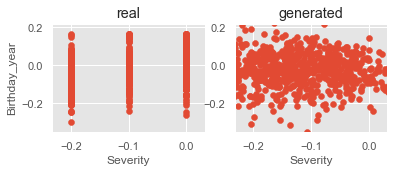

Step: 5000 of 85011.
Losses: G, D Gen, D Real, Xgb: 0.7737, 0.6813, 0.5264, 1.0000
D Real - D Gen: -0.1549


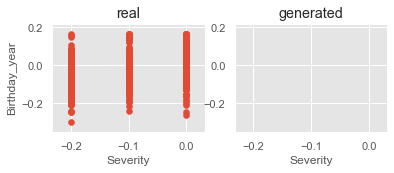

Step: 10000 of 85011.
Losses: G, D Gen, D Real, Xgb: 0.7621, 0.6676, 0.6270, 0.9989
D Real - D Gen: -0.0406


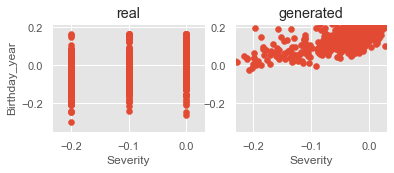

Step: 15000 of 85011.
Losses: G, D Gen, D Real, Xgb: 0.7763, 0.6923, 0.5921, 0.9989
D Real - D Gen: -0.1001


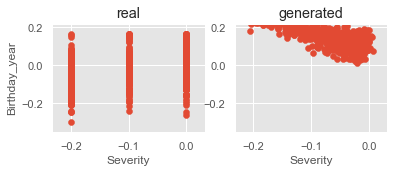

Step: 20000 of 85011.
Losses: G, D Gen, D Real, Xgb: 0.8756, 0.6746, 0.7921, 0.9878
D Real - D Gen: 0.1175


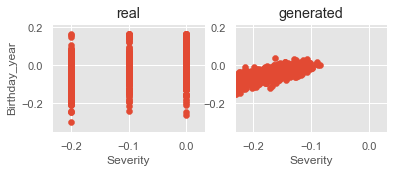

Step: 25000 of 85011.
Losses: G, D Gen, D Real, Xgb: 1.1407, 0.4367, 0.8439, 1.0000
D Real - D Gen: 0.4072


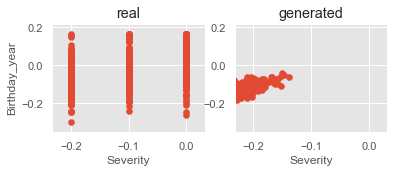

Step: 30000 of 85011.
Losses: G, D Gen, D Real, Xgb: 0.4158, 1.3259, 0.6456, 1.0000
D Real - D Gen: -0.6803


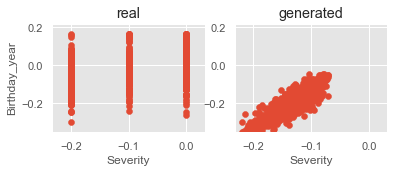

Step: 35000 of 85011.
Losses: G, D Gen, D Real, Xgb: 1.6224, 0.2345, 1.3407, 1.0000
D Real - D Gen: 1.1062


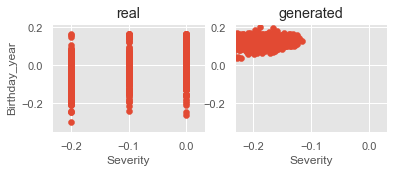

Step: 40000 of 85011.
Losses: G, D Gen, D Real, Xgb: 0.0303, 4.0902, 0.7856, 1.0000
D Real - D Gen: -3.3046


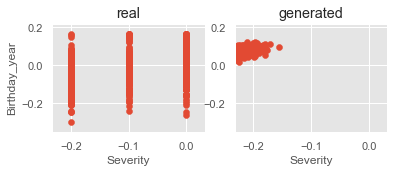

Step: 45000 of 85011.
Losses: G, D Gen, D Real, Xgb: 0.0648, 3.3267, 0.4822, 0.9989
D Real - D Gen: -2.8445


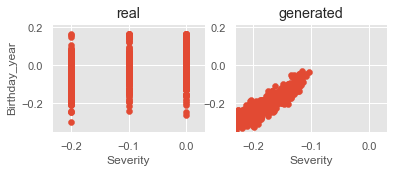

Step: 50000 of 85011.
Losses: G, D Gen, D Real, Xgb: 0.9687, 0.4895, 0.5509, 1.0000
D Real - D Gen: 0.0614


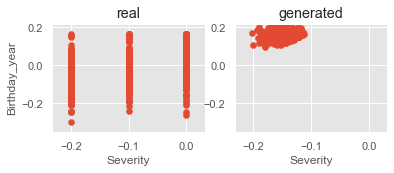

Step: 55000 of 85011.
Losses: G, D Gen, D Real, Xgb: 1.3259, 0.3318, 0.6232, 1.0000
D Real - D Gen: 0.2915


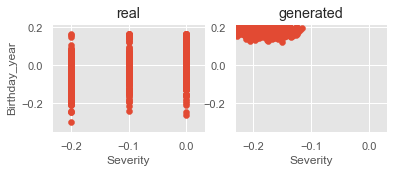

Step: 60000 of 85011.
Losses: G, D Gen, D Real, Xgb: 1.0101, 0.4613, 0.5501, 1.0000
D Real - D Gen: 0.0888


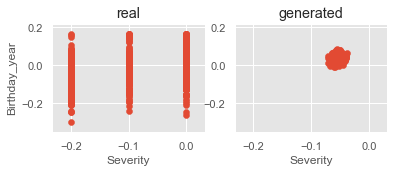

Step: 65000 of 85011.
Losses: G, D Gen, D Real, Xgb: 1.3301, 0.3461, 0.6179, 1.0000
D Real - D Gen: 0.2718


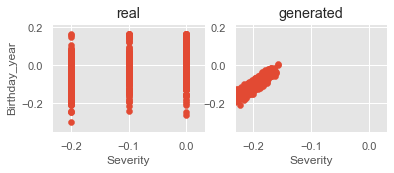

Step: 70000 of 85011.
Losses: G, D Gen, D Real, Xgb: 1.2197, 0.3965, 0.5419, 1.0000
D Real - D Gen: 0.1454


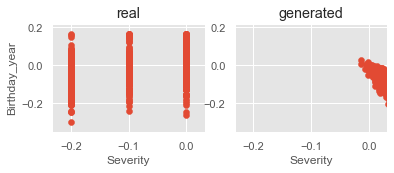

Step: 75000 of 85011.
Losses: G, D Gen, D Real, Xgb: 0.6856, 1.1383, 1.4404, 1.0000
D Real - D Gen: 0.3021


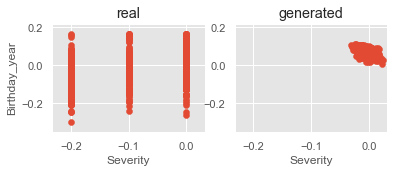

Step: 80000 of 85011.
Losses: G, D Gen, D Real, Xgb: 0.3595, 1.2230, 0.1479, 1.0000
D Real - D Gen: -1.0751


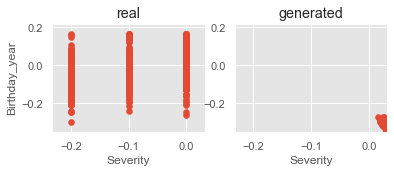

Step: 85000 of 85011.
Losses: G, D Gen, D Real, Xgb: 1.1205, 0.4199, 0.5268, 1.0000
D Real - D Gen: 0.1068


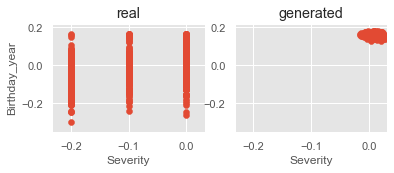

data_dim:  10
data_cols:  ['Severity', 'Birthday_year', 'Parents or siblings infected', 'Wife/Husband or children infected', 'Medical_Expenses_Family', 'Medical_Tent', 'City', 'Gender', 'family_infected', 'is_alone']
label_dim:  1
label_cols:  ['Deceased']
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, 11)]         0                                            
__________________________________________________________________________________________________
input_55 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_18 (Concatenate)    (None, 12)           0           input_54[0][0]                   
                               

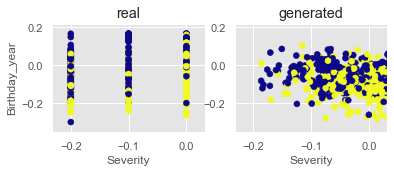

Step: 5000 of 85011.
Losses: G, D Gen, D Real, Xgb: 0.7155, 0.6771, 0.6801, 0.9944
D Real - D Gen: 0.0030


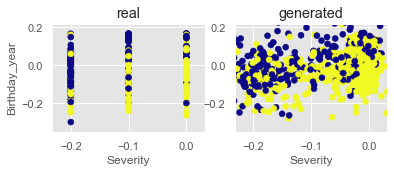

Step: 10000 of 85011.
Losses: G, D Gen, D Real, Xgb: 0.7741, 0.6416, 0.6341, 0.9933
D Real - D Gen: -0.0075


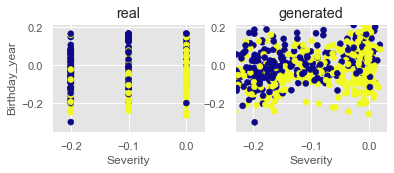

Step: 15000 of 85011.
Losses: G, D Gen, D Real, Xgb: 1.0450, 0.5290, 0.5069, 0.9978
D Real - D Gen: -0.0221


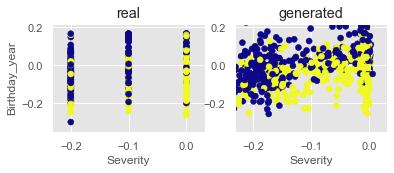

Step: 20000 of 85011.
Losses: G, D Gen, D Real, Xgb: 1.7334, 0.2991, 0.3228, 0.9956
D Real - D Gen: 0.0238


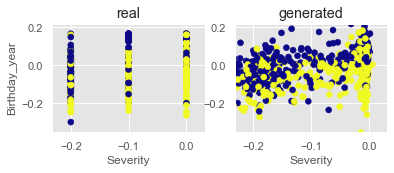

Step: 25000 of 85011.
Losses: G, D Gen, D Real, Xgb: 2.9626, 0.1777, 0.2218, 0.9956
D Real - D Gen: 0.0441


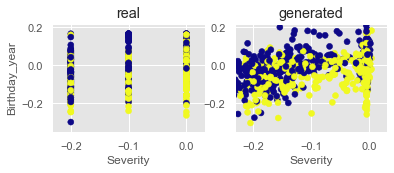

Step: 30000 of 85011.
Losses: G, D Gen, D Real, Xgb: 3.9384, 0.1800, 0.1685, 0.9978
D Real - D Gen: -0.0115


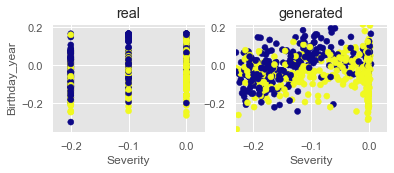

Step: 35000 of 85011.
Losses: G, D Gen, D Real, Xgb: 5.5073, 0.0532, 0.1306, 0.9978
D Real - D Gen: 0.0773


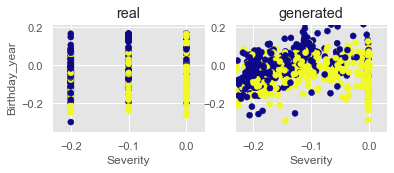

Step: 40000 of 85011.
Losses: G, D Gen, D Real, Xgb: 4.9209, 0.0654, 0.2550, 0.9956
D Real - D Gen: 0.1896


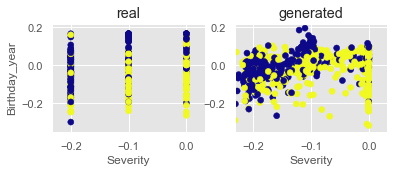

Step: 45000 of 85011.
Losses: G, D Gen, D Real, Xgb: 5.7084, 0.0881, 0.0460, 0.9989
D Real - D Gen: -0.0420


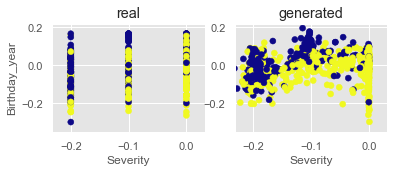

Step: 50000 of 85011.
Losses: G, D Gen, D Real, Xgb: 6.0233, 0.1768, 0.1920, 1.0000
D Real - D Gen: 0.0152


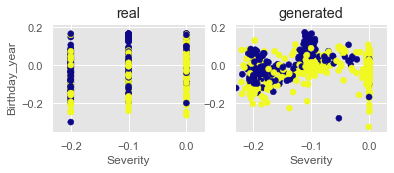

Step: 55000 of 85011.
Losses: G, D Gen, D Real, Xgb: 6.7021, 0.2322, 0.0119, 0.9944
D Real - D Gen: -0.2203


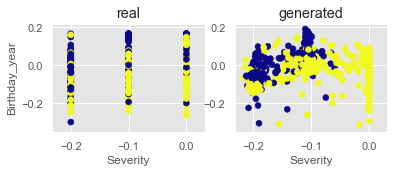

Step: 60000 of 85011.
Losses: G, D Gen, D Real, Xgb: 5.9306, 0.0296, 0.0222, 0.9989
D Real - D Gen: -0.0074


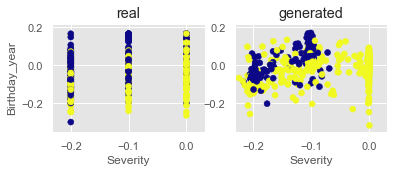

Step: 65000 of 85011.
Losses: G, D Gen, D Real, Xgb: 6.2566, 0.0499, 0.1071, 0.9933
D Real - D Gen: 0.0571


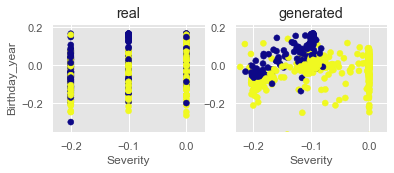

Step: 70000 of 85011.
Losses: G, D Gen, D Real, Xgb: 7.3891, 0.0073, 0.1001, 0.9989
D Real - D Gen: 0.0929


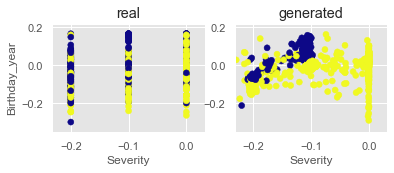

Step: 75000 of 85011.
Losses: G, D Gen, D Real, Xgb: 7.4255, 0.0331, 0.0752, 0.9978
D Real - D Gen: 0.0421


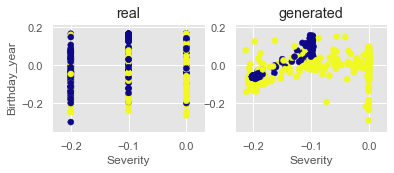

Step: 80000 of 85011.
Losses: G, D Gen, D Real, Xgb: 7.3219, 0.0112, 0.0370, 1.0000
D Real - D Gen: 0.0258


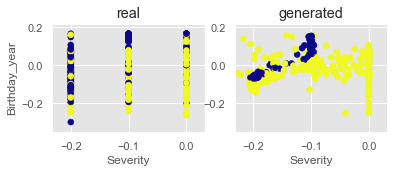

Step: 85000 of 85011.
Losses: G, D Gen, D Real, Xgb: 7.7113, 0.0629, 0.0448, 0.9911
D Real - D Gen: -0.0181


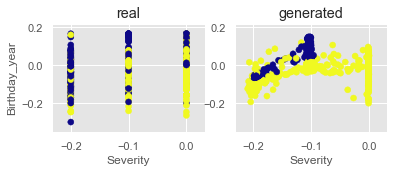

Wall time: 43min 41s


In [205]:
%%time

learning_rate = 5e-5 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols=data_cols ) # GAN - only uses training set sem labels 
adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN


#### Generate new data for GAN and CGAN and check the accuracy for the CGAN

It's not possible to check the accuracy of GAN, since it doesn't generate labels in the synthetic data.

In [243]:
data_dim = len(data_cols)
label_dim = len(label_cols)

def generate_new_data(model):
    seed = 17
    np.random.seed(seed)
    if model == 'CGAN':
        generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
        generator_model.load_weights('cache/CGAN_generator_model_weights_step_65000.h5')
        with_class = True
    else:
        generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
        generator_model.load_weights('cache/GAN_generator_model_weights_step_65000.h5')
        with_class = False

    # Now generate some new data

    test_size = train[train[label_cols] == 1.0].shape[0] # Equal to all of deceased cases

    x = get_data_batch(train, test_size, seed=17) 
    z = np.random.normal(size=(test_size, rand_dim))
    if with_class == True:
        labels = x[:,-label_dim:]
        g_z = generator_model.predict([z, labels])

    elif with_class == False:
        g_z = generator_model.predict(z)
     
    return g_z, x, generator_model, z, x

Generating data with GAN:

In [244]:
gan_z,gan_x, gan_generator_model, z, x = generate_new_data('GAN')
GAN_sample = pd.DataFrame(gan_z, columns=data_cols)
GAN_sample

,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Gender,family_infected,is_alone
0,-0.232209,-0.190011,-0.015808,0.049641,0.770133,-0.403273,0.171211,-0.101545,-0.093467,-0.014695
1,-0.195525,-0.079335,0.017354,0.058704,0.653276,-0.333503,0.139852,-0.085591,-0.067227,-0.027230
2,-0.190893,-0.097909,0.015112,0.061177,0.626123,-0.337113,0.131319,-0.083737,-0.061995,-0.026772
3,-0.215229,-0.156869,0.005246,0.063226,0.728462,-0.368221,0.154766,-0.092988,-0.088279,-0.018874
4,-0.194882,-0.088131,0.020548,0.075180,0.640962,-0.314638,0.118996,-0.066141,-0.043089,-0.029063
...,...,...,...,...,...,...,...,...,...,...
895,-0.191164,-0.120489,-0.001965,0.064734,0.676422,-0.333590,0.137159,-0.086854,-0.058072,-0.029730
896,-0.174336,-0.061633,0.018100,0.056968,0.575649,-0.297714,0.119524,-0.072611,-0.052932,-0.028200
897,-0.190836,-0.091881,0.012196,0.065299,0.619379,-0.312709,0.130782,-0.080734,-0.056191,-0.028246
898,-0.207672,-0.098470,-0.000073,0.069930,0.675509,-0.349352,0.134662,-0.092100,-0.056139,-0.023800


Generating data with CGAN:

In [245]:
cgan_z,cgan_x, cgan_generator_model, z, x = generate_new_data('CGAN')
CGAN_sample = pd.DataFrame(cgan_z, columns=data_cols+label_cols)
CGAN_sample

,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Gender,family_infected,is_alone,Deceased
0,0.000223,-0.031192,0.000155,-0.000194,-0.029467,0.024683,0.000106,-0.000055,0.000803,-0.000085,1.0
1,-0.099225,0.162256,0.201953,0.097129,0.128625,-0.109874,0.114897,-0.109257,0.301776,-0.101031,0.0
2,-0.098484,0.163665,0.199659,0.096919,0.124050,-0.108622,0.116373,-0.106412,0.301499,-0.101520,0.0
3,-0.198764,-0.129165,0.095655,0.093425,0.411756,-0.080317,0.101816,-0.000990,0.194210,-0.098150,1.0
4,-0.113279,-0.110876,0.004365,0.135233,0.162657,-0.060048,0.139807,-0.001175,0.148400,-0.109130,1.0
...,...,...,...,...,...,...,...,...,...,...,...
895,0.000105,0.021180,0.000179,0.000031,-0.031939,0.018238,0.000040,-0.000128,0.000264,-0.000007,1.0
896,0.000143,0.033976,0.000245,0.000146,-0.029536,0.021080,0.000056,-0.000130,0.000130,-0.000065,1.0
897,-0.097839,0.152544,0.197243,0.099186,0.121067,-0.111553,0.106839,-0.104883,0.295988,-0.098913,0.0
898,0.000023,0.043169,0.000221,0.000089,-0.031489,0.037706,0.000088,-0.000160,0.000061,-0.000128,1.0


#### Data distribuition plots of the last step during the GAN and CGAN training

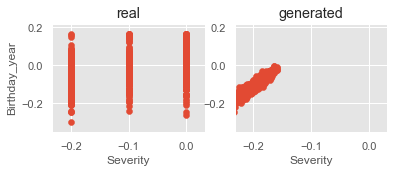

In [246]:
#GAN 
PlotData( gan_x, gan_z, data_cols, label_cols, seed=0, with_class=False, data_dim=data_dim )

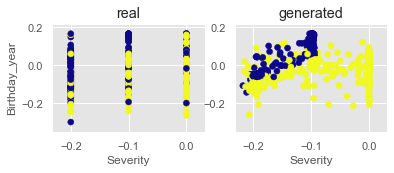

In [247]:
#CGAN
PlotData( cgan_x, cgan_z, data_cols, label_cols, seed=0, with_class=True, data_dim=data_dim )

For the next few plots, we will use the CGAN only because it generates labels unlike GAN.

#### Compare the real and generated data by class, along every feature

In [248]:
real_samples = pd.DataFrame(cgan_x, columns=data_cols+label_cols)
test_samples = pd.DataFrame(cgan_z, columns=data_cols+label_cols)

training_fraction = 0.5
n_real, n_test = int(len(real_samples)*training_fraction), int(len(test_samples)*training_fraction)
train_df1 = pd.concat([real_samples[:n_real],test_samples[:n_test]],axis=0)
test_df = pd.concat([real_samples[n_real:],test_samples[n_test:]],axis=0)

X_col = test_df.columns[:-1]

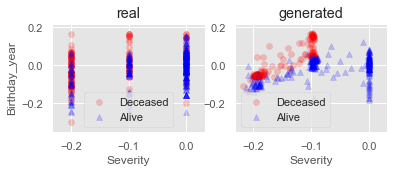

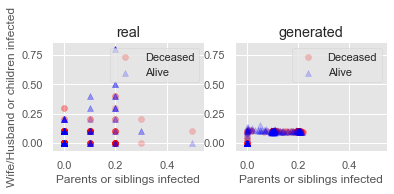

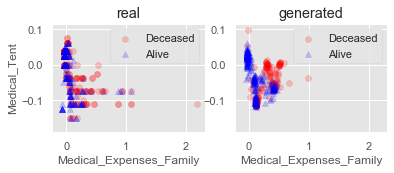

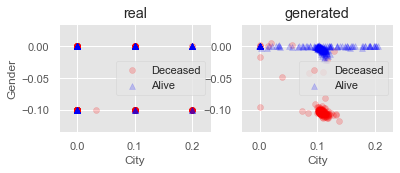

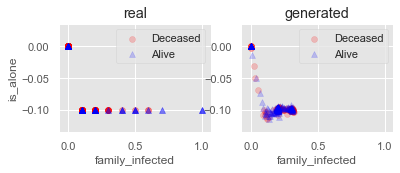

In [249]:
colors = ['red','blue']
markers = ['o','^']
labels = ['Deceased','Alive'] 

class_label = 'Deceased'

for i in range(0,len(X_col), 2):
    col1, col2 = i, i+1
    if i+1 >= len(X_col): continue
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    for group, color, marker, label in zip( test_df[:n_real].groupby(class_label), colors, markers, labels ):
        axarr[0].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[0].legend()
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[col2])

    for group, color, marker, label in zip( test_df[n_real:].groupby(class_label), colors, markers, labels ):
        axarr[1].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())
    axarr[1].legend()
    axarr[1].set_title('generated') 

    for a in axarr:
        a.set_xlabel(X_col[col1])

    plt.show()

### Comparison of GAN and CGAN distributions with the real data

Choosing the variables to plot their distribuitions.

In [250]:
train_df.columns

Index(['Severity', 'Birthday_year', 'Parents or siblings infected',
       'Wife/Husband or children infected', 'Medical_Expenses_Family',
       'Medical_Tent', 'City', 'Gender', 'family_infected', 'is_alone',
       'Deceased'],
      dtype='object')

In [251]:
# From the list above, choose two the two feautures that you want to see together.
col1, col2 = 'is_alone', 'Birthday_year' 

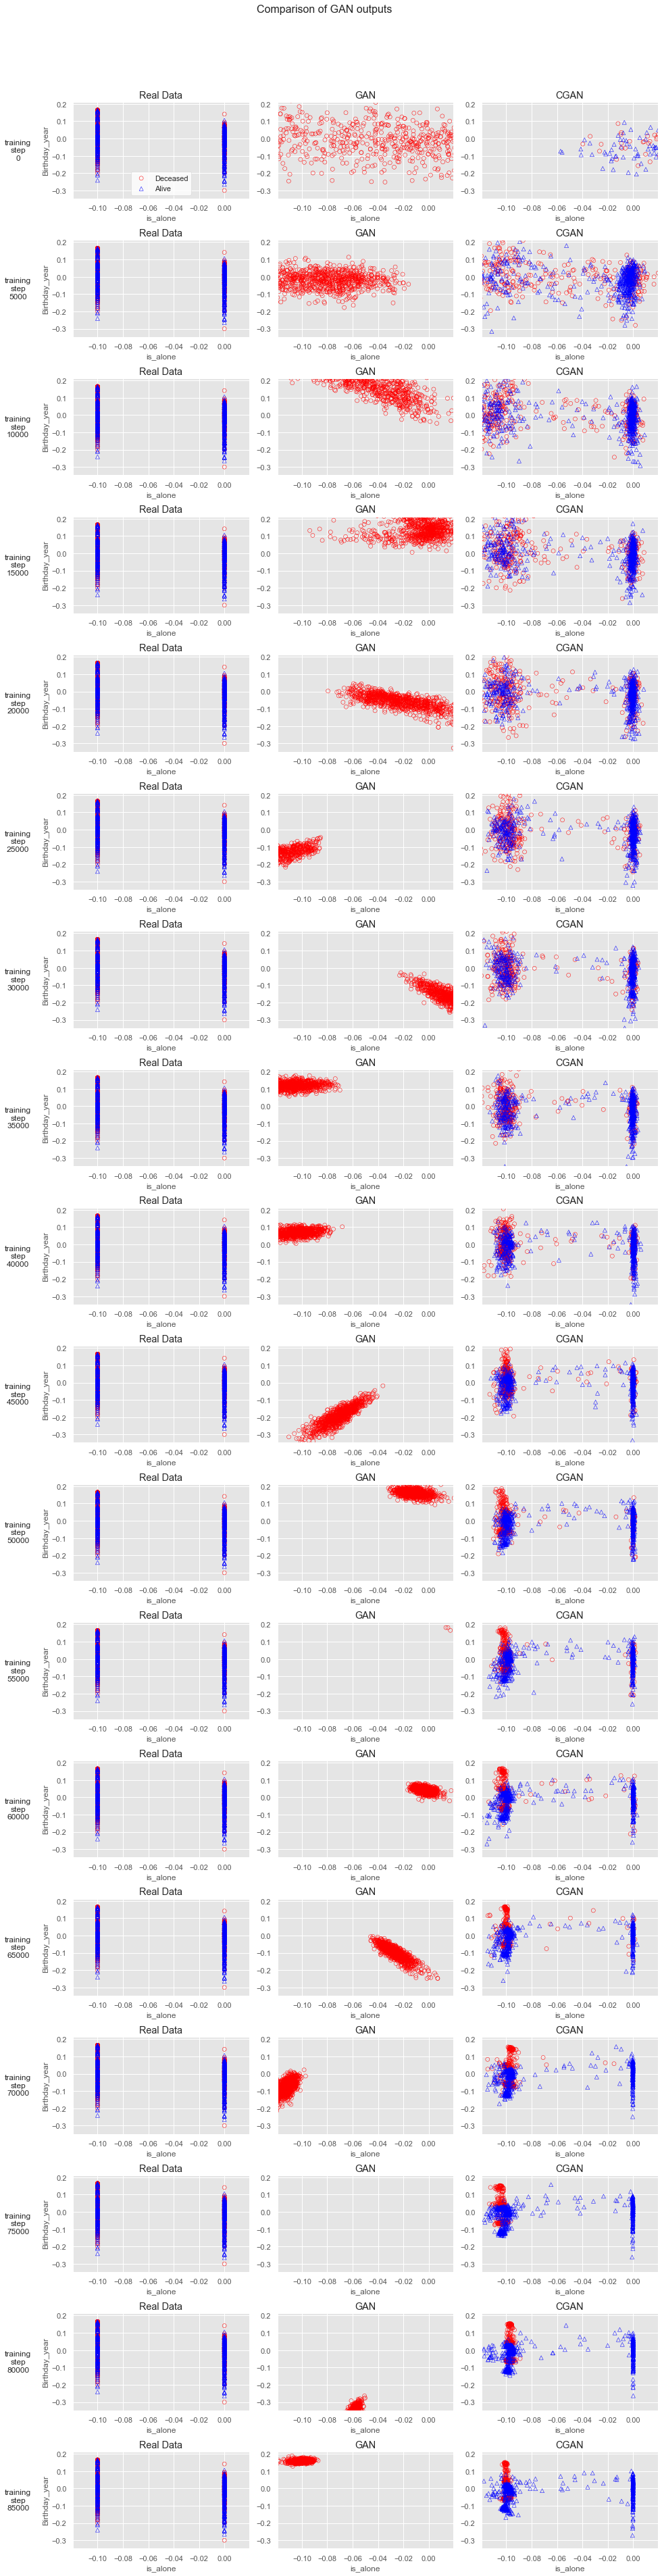

In [252]:
class_labels = ['Deceased','Alive'] 
colors = ['red','blue']
markers = ['o','^']
base_dir = 'cache/'
model_names = ['GAN','CGAN']
with_classes = [False, True]

generator_model = [gan_generator_model,cgan_generator_model]

labels = x[:,-label_dim:]

models = {}
for model_name, with_class, generator_model in zip(model_names, with_classes,generator_model):

    models[model_name] = [ model_name, with_class, generator_model ]


model_steps = [ 0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000]

rows = len(model_steps)
columns = 3 

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate( model_steps ):

    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip( real_samples.groupby('Deceased'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Real Data')
    plt.ylabel(col2) 
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
        
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):
        
        [ model_name, with_class, generator_model ] = models[model_name]
        
        generator_model.load_weights( base_dir + model_name + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )
        
        if with_class == True:

            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Deceased'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        elif with_class == False:

            g_z = generator_model.predict(z)
            
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(col1)
        ax.set_xlim(xlims), ax.set_ylim(ylims)


plt.suptitle('Comparison of GAN outputs', size=16)
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

# plt.savefig('plots/Comparison_of_GAN_outputs.png')

### Compare the losses and accuracy of the GAN and CGAN

In [253]:
# First we need to Load the saved loss data from each model

base_dir = 'cache/'
suffix = '_step_90000'

GAN_losses = pickle.load(open(base_dir + 'GAN_losses'+suffix+'.pkl','rb'))
CGAN_losses = pickle.load(open(base_dir + 'CGAN_losses'+suffix+'.pkl','rb'))

#### Find best xgb scores overall and every x step

In [254]:
step = 100
data_ix = 3
data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix]]
labels = [ 'GAN','CGAN']

for label, data_set in zip( labels, data_sets ):
    best_step = list(data_set).index( np.array(data_set).min() ) * 10
    print( '{: <5} step {: <4}: {:.4f}'.format( label, best_step, np.array(data_set).min() ) )

    xgb_step = [ data_set[i] for i in range(0, len(data_set), int(step/10)) ]
    best_step = xgb_step.index( min(xgb_step) ) * 100
    print( '{: <5} step {: <4}: {:.4f}\n'.format( label, best_step, np.array(xgb_step).min() ) )

GAN   step 63410: 0.9667
GAN   step 10200: 0.9833

CGAN  step 38800: 0.9711
CGAN  step 38800: 0.9711



#### Plotting the losses without smoothing

<Figure size 504x216 with 0 Axes>

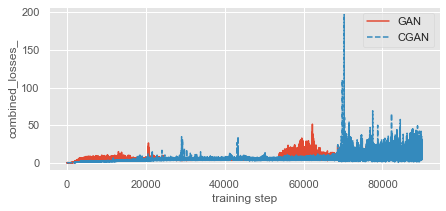

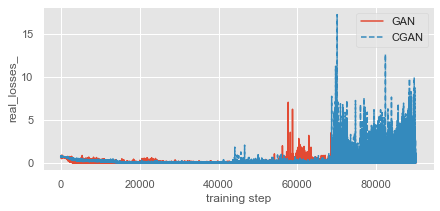

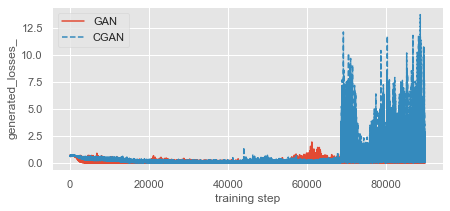

In [255]:
data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_']
sampling_intervals = [ 1, 1, 1]
labels = [ 'GAN','CGAN']
linestyles = ['-', '--']

fig = plt.figure(figsize=(7,3))
for data_ix in range(len(data_fields)):
    data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix]]

    plt.figure(figsize=(7,3))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 data,
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()

#### Plotting the smoothed losses

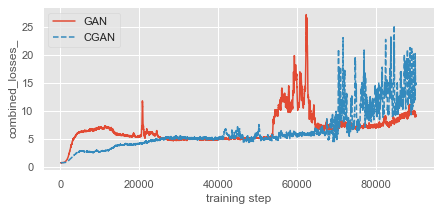

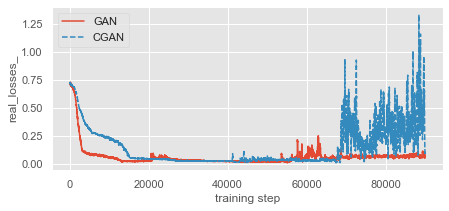

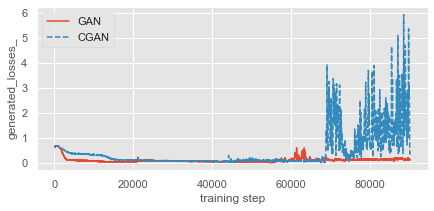

In [256]:
w = 100
for data_ix in range(len(data_fields)):
    data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix]]

    plt.figure(figsize=(7,3))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 pd.DataFrame(data).rolling(w).mean(),
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()

#### Accuracy of the generated data detection

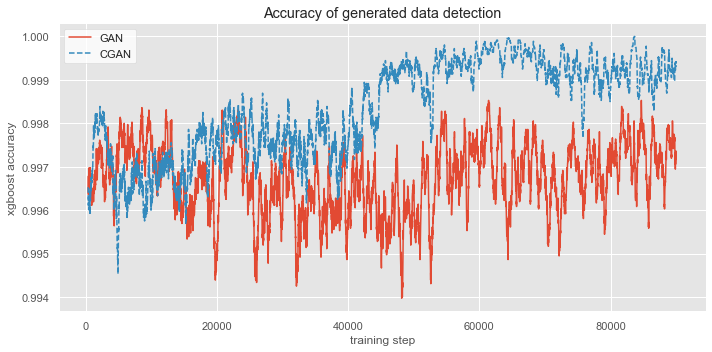

In [257]:
w = 40
data_ix = 3 # this index correspondes to 'xgb_losses'

data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix]]

plt.figure(figsize=(10,5))
for data, label, linestyle in zip(data_sets, labels, linestyles):
    plt.plot( np.array(range(0,len(data)))*10,
             pd.DataFrame(data).rolling(w).mean(),
             label=label, linestyle=linestyle )

plt.ylabel('xgb_losses')
plt.xlabel('training step')
legend = plt.legend() 
legend.get_frame().set_facecolor('white')

plt.title('Accuracy of generated data detection')
plt.ylabel('xgboost accuracy')
plt.tight_layout() ;
# plt.savefig('plots/GAN_accuracy.png')

Overall, not only CGAN performs better than GAN, but also synthesizes labels and data together. So, we will use it naive bayes classification.

In [258]:
generated_df = pd.DataFrame(cgan_z, columns=data_cols+label_cols)
generated_df[ data_cols ] = generated_df[ data_cols ] 
generated_df

,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Gender,family_infected,is_alone,Deceased
0,0.000223,-0.031192,0.000155,-0.000194,-0.029467,0.024683,0.000106,-0.000055,0.000803,-0.000085,1.0
1,-0.099225,0.162256,0.201953,0.097129,0.128625,-0.109874,0.114897,-0.109257,0.301776,-0.101031,0.0
2,-0.098484,0.163665,0.199659,0.096919,0.124050,-0.108622,0.116373,-0.106412,0.301499,-0.101520,0.0
3,-0.198764,-0.129165,0.095655,0.093425,0.411756,-0.080317,0.101816,-0.000990,0.194210,-0.098150,1.0
4,-0.113279,-0.110876,0.004365,0.135233,0.162657,-0.060048,0.139807,-0.001175,0.148400,-0.109130,1.0
...,...,...,...,...,...,...,...,...,...,...,...
895,0.000105,0.021180,0.000179,0.000031,-0.031939,0.018238,0.000040,-0.000128,0.000264,-0.000007,1.0
896,0.000143,0.033976,0.000245,0.000146,-0.029536,0.021080,0.000056,-0.000130,0.000130,-0.000065,1.0
897,-0.097839,0.152544,0.197243,0.099186,0.121067,-0.111553,0.106839,-0.104883,0.295988,-0.098913,0.0
898,0.000023,0.043169,0.000221,0.000089,-0.031489,0.037706,0.000088,-0.000160,0.000061,-0.000128,1.0


In [259]:
CGAN_train_data = generated_df.drop(columns = ['Deceased'])
CGAN_train_target = generated_df.Deceased

In [260]:
naive_bayes_classifier(CGAN_train_data,CGAN_train_target)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       260
         1.0       0.98      0.99      0.99       415

    accuracy                           0.98       675
   macro avg       0.98      0.98      0.98       675
weighted avg       0.98      0.98      0.98       675

[[252   8]
 [  4 411]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

As we can see here, the resulting classification is equivalent to our real dataset baseline and also better than the CTGAN baseline as intended.